# Telling the History of a District with Open Data

![title](./data/pexels-tima-miroshnichenko-7033891-20220313-154950.jpg)

**Data** taken from: 

* Main Dataset - containing all the informations about the buildings:

https://www.data.gv.at/katalog/dataset/wien-geschichte-wiki/resource/a230cfe8-95d9-474a-9436-fe6659a4e40d

* Boundaries of the 7th district:

https://www.data.gv.at/katalog/dataset/stadt-wien_bezirksgrenzenwien#additional-info

## Step 0: Load Libraries & Data

in the following code chunks we are:

* loading the necessary libraries and the dataset
* looking at some sample rows

In [1]:
#standard libraries
import os
import pandas as pd
import numpy as np
import regex as re

#for visuals
import matplotlib.pyplot as plt

#for webscraping
from urllib.request import urlopen

In [62]:
df = pd.read_csv('./data/KULTURWIKIOGD.csv')

In [63]:
df.head(3)

,FID,OBJECTID,SHAPE,ADRESSE,ANDERE_BEZEICHNUNG,ART_DER_ORGANISATION,ART_DES_BAUWERKS,ART_DES_EREIGNISSES,ART_DES_OBJEKTS,BENANNT_NACH,...,KATEGORIE_TXT,LAGE,NAME_SEIT,PAGEID,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,SEITENNAME,STADTPLAN,WEBLINK1,SE_ANNO_CAD_DATA
0,KULTURWIKIOGD.fid-52c6621a_186c0bfb22a_-7e62,294006,POINT (16.244504291918773 48.207665864191334),"14., Mondweg 91",NaN,NaN,NaN,NaN,Grünfläche,Franz Sauer,...,topografische_objekte,Wolfersberg,NaN,24895,NaN,NaN,Franz-Sauer-Park,1,https://www.geschichtewiki.wien.gv.at/?curid=2...,NaN
1,KULTURWIKIOGD.fid-52c6621a_186c0bfb22a_-7e61,294007,POINT (16.258101639280678 48.19710480431093),"13., Rußpekgasse 3",NaN,NaN,NaN,NaN,Grünfläche,Franz Schimon,...,topografische_objekte,Hacking,NaN,45236,NaN,NaN,Franz-Schimon-Park,1,https://www.geschichtewiki.wien.gv.at/?curid=4...,NaN
2,KULTURWIKIOGD.fid-52c6621a_186c0bfb22a_-7e60,294008,POINT (16.2606861380513 48.18231434166762),"13., Schweizertalstraße 29D",NaN,NaN,NaN,NaN,Grünfläche,Franz Schmidt,...,topografische_objekte,NaN,NaN,31479,NaN,NaN,Franz-Schmidt-Park,1,https://www.geschichtewiki.wien.gv.at/?curid=3...,NaN


## Step 1: First Analysis & Filter

In the following code chunks we are:

* creating a column for the district and one for the street out of the existing
  "adresse" which contains both information
* counting the number of objects per district

In [64]:
df['DISTRICT'] = df['ADRESSE'].str[0:2]
df['STREET'] = df['ADRESSE'].str[5:]

In [65]:
pd.DataFrame(df.sort_values(by=['DISTRICT'])['DISTRICT'].value_counts(sort=False)).style


,DISTRICT
01,2573
02,888
03,852
04,369
05,277
06,386
07,350
08,308
09,558
10,787


In [66]:
df_filtered = df[df['DISTRICT'] == '07']
pd.DataFrame(df_filtered.count()).style


,0
FID,350
OBJECTID,350
SHAPE,350
ADRESSE,350
ANDERE_BEZEICHNUNG,30
ART_DER_ORGANISATION,30
ART_DES_BAUWERKS,139
ART_DES_EREIGNISSES,1
ART_DES_OBJEKTS,85
BENANNT_NACH,113


Next we are

* looking at the row with the least missing values to find out more about what the different column contain
* dropping unnessary columns
* looking at some summary graphics to gains some insights about the data

In [7]:
df_filtered[df_filtered.isnull().sum(axis=1) == min(df_filtered.isnull().sum(axis=1))].head(1).style

,FID,OBJECTID,SHAPE,ADRESSE,ANDERE_BEZEICHNUNG,ART_DER_ORGANISATION,ART_DES_BAUWERKS,ART_DES_EREIGNISSES,ART_DES_OBJEKTS,BENANNT_NACH,BEZIRK,BEZIRK_TXT,DATUM_BIS,DATUM_VON,EINLAGEZAHL,FRUEHERE_BEZEICHNUNG,KATEGORIE,KATEGORIE_TXT,LAGE,NAME_SEIT,PAGEID,PROMINENTE_BEWOHNER,PROMINENTE_PERSONEN,SEITENNAME,STADTPLAN,WEBLINK1,SE_ANNO_CAD_DATA,DISTRICT,STREET
2021,KULTURWIKIOGD.fid-52c6621a_186c0bfb22a_-767d,290160,POINT (16.351523540077157 48.20555287080875),"07., Neustiftgasse 30",nan,nan,nan,nan,Verkehrsfläche,Georg Kellermann,7.000000,7,nan,1910.000000,nan,Schottenhofgasse,0,TopografischeObjekte,nan,20 Mai 1910,3419,Max Devrient,nan,Kellermanngasse,1,https://www.geschichtewiki.wien.gv.at/?curid=3419,nan,07,Neustiftgasse 30


In [8]:
df_filtered = df_filtered.drop(columns=['FID','OBJECTID', 'ADRESSE', 'BEZIRK', 'BEZIRK_TXT', 'EINLAGEZAHL',
                    'FRUEHERE_BEZEICHNUNG', 'KATEGORIE', 'LAGE', 'PAGEID', 'STADTPLAN', 
                   'PROMINENTE_BEWOHNER', 'PROMINENTE_PERSONEN', 'SE_ANNO_CAD_DATA'], inplace=False)

<AxesSubplot:>

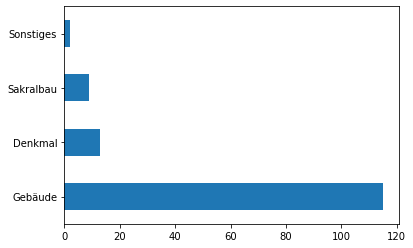

In [9]:
df_filtered.ART_DES_BAUWERKS.value_counts().plot(kind='barh')

<AxesSubplot:>

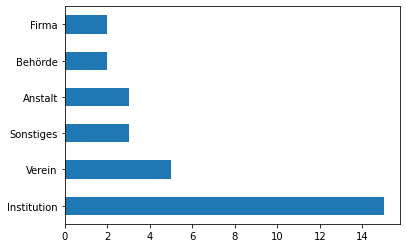

In [10]:
df_filtered.ART_DER_ORGANISATION.value_counts().plot(kind='barh')

<AxesSubplot:>

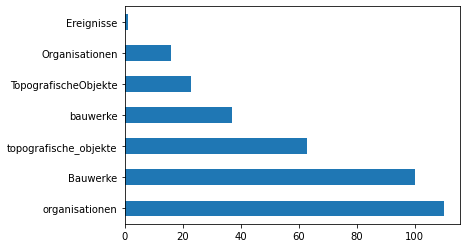

In [11]:
df_filtered.KATEGORIE_TXT.value_counts().plot(kind='barh')

### Step 1.1: Analysis of Missing Values

Next we are looking at some summary statistics on the number of values that 
we have available for the different columns in our data set.

In [3]:
def visualize_missing_values(dataframe):
    """
    method to visualize the number of missing and available values per column
    """
    numer_of_na = dataframe.isnull().sum(axis = 0)
    numer_of_na = numer_of_na.to_frame()

    numer_of_a = dataframe.notnull().sum(axis = 0)
    numer_of_a = numer_of_a.to_frame()

    index = numer_of_na

    #specify resolution
    plt.figure(figsize=(14, 3), dpi=120)

    #print bars
    plt.bar(numer_of_na.index, height=numer_of_a[0], color='#6ce083', label='Available')
    plt.bar(numer_of_na.index, bottom=numer_of_a[0], height=numer_of_na[0], color='#899a9f', label='Not Available')
    plt.legend(loc='center right')
    plt.title('Overview of Missing Values')

    #show values of bars
    for index, value in enumerate(numer_of_a[0]):
        plt.text(index, value, str(value),  ha='left', va='top',)

    #label the plot
    plt.xlabel('Features')
    plt.ylabel('Number of Available Data Records')

    #rotate x labels
    _ = plt.xticks(rotation=75)


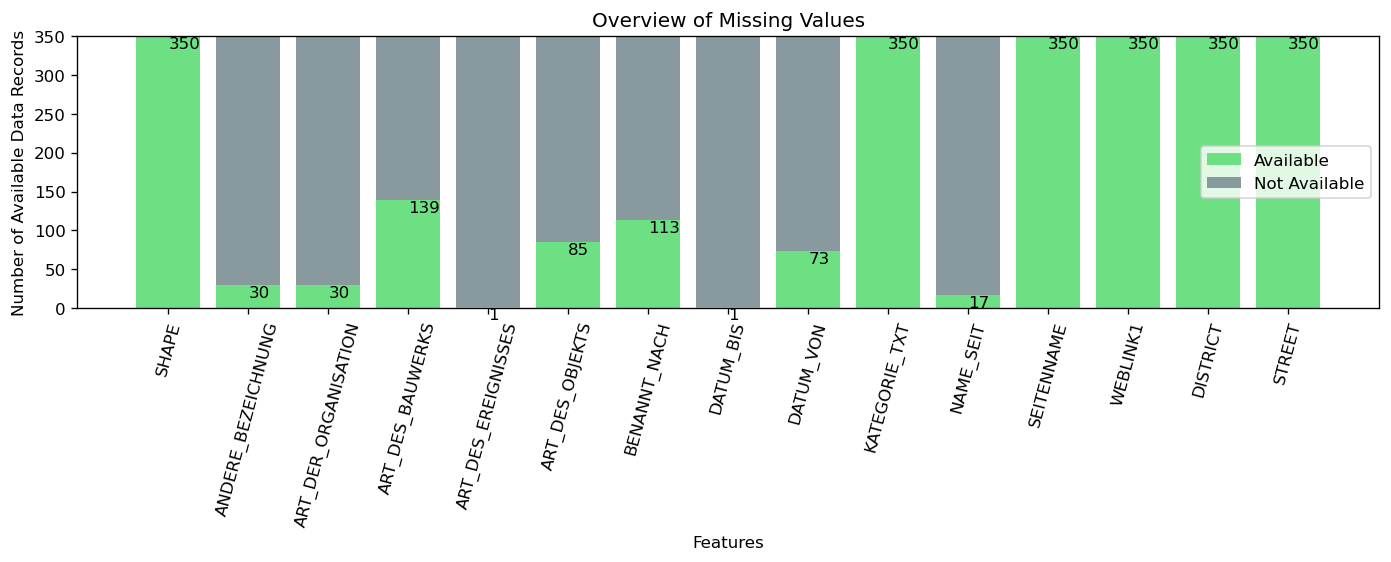

In [13]:
visualize_missing_values(df_filtered)

## Step 2: Extending the Dataset by Webscraping

The analysis in the last step showed that a range of essential values appear to be missing.

Luckily I found out that the information on some missing values is available on the Wien wiki website.

That is why we are now scraping the wien wiki website for the different pages on the different objects.

In [14]:
def look_up_facts(url):
    """ 
    method that takes as input
    a link to a page of wien wiki
    and return information (date of the object, etc.)
    that can be found on the webpage
    """

    #open the page
    page = urlopen(url)

    #read html and convert it to a string
    html_bytes = page.read()
    html = str(html_bytes.decode("utf-8"))

    #find the start year
    marker = '<td><span class="smw-property nolink">'
    position = html.find(marker+'Datum von')
    try:
        year_begin = int(html[position:position+69][-4:])
    except:
        if "ersten Bauphase des Spittelbergviertels" in html:
            year_begin = 1725
        else:
            year_begin = None
            #if "Jahrhundert" in html[:html.find('id="Literatur">')]: 
                #try:
                 #   century = re.findall(r"\d+...Jahrhundert",html)[0]
                 #   century = re.findall(r"\d+",century)[0]
                  #  year_begin = (int(century)*100)-100

                  #  if "zweite Hälfte" in html or "Ende des" in html:
                   #     year_begin += 50
                #except:
                   # year_begin = None
            
           # else:
              #  year_begin = None

    #find the end year
    position = html.find(marker+'Datum bis')
    try:
        year_end = int(html[position:position+69][-4:])
    except:
        year_end = None

    #find the type of object
    position = html.find(marker+'Art')
    object_type = html[position:position+150]
    
    if 'title=' in object_type:
        object_type = object_type[object_type.find('title='):object_type.find('&amp;')]
        object_type = re.sub('<.*>|"|<.*|>.*|\\|\n|\\n|title=', "", object_type).strip()
    else:
        object_type = None

    return year_begin, year_end, object_type


print(look_up_facts('https://www.geschichtewiki.wien.gv.at/Wien_Geschichte_Wiki?curid=12421'))
print(look_up_facts('https://www.geschichtewiki.wien.gv.at/?curid=25703'))
print(look_up_facts('https://www.geschichtewiki.wien.gv.at/?curid=69557'))




(1783, None, 'Apotheke')
(None, None, 'Sakrale_Freiplastik')
(None, None, 'Verlag')


In [15]:
%%capture
row_counter=0
import numpy as np

df_filtered['OBJECTTYPE'] = ''

for i in df_filtered.iterrows():
    
    #look up the information on the web
    year_begin, year_end, object_type  = look_up_facts(df_filtered['WEBLINK1'].iloc[row_counter])

    if year_begin != None and np.isnan(df_filtered['DATUM_VON'].iloc[row_counter]):
        df_filtered['DATUM_VON'].iloc[row_counter] = year_begin

    if year_end != None and np.isnan(df_filtered['DATUM_BIS'].iloc[row_counter]):
        df_filtered['DATUM_BIS'].iloc[row_counter] = year_end

    df_filtered['OBJECTTYPE'].iloc[row_counter] = object_type
        
    row_counter +=1

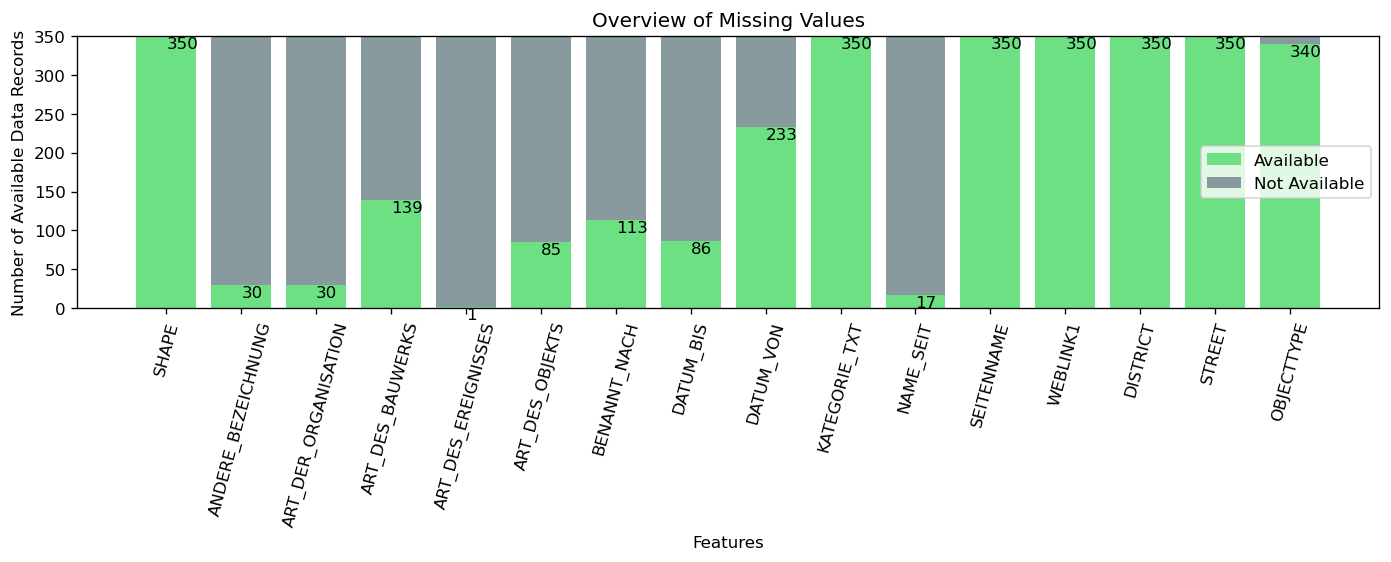

In [16]:
visualize_missing_values(df_filtered)

In [17]:
df_filtered[df_filtered['OBJECTTYPE'].isna()]

,SHAPE,ANDERE_BEZEICHNUNG,ART_DER_ORGANISATION,ART_DES_BAUWERKS,ART_DES_EREIGNISSES,ART_DES_OBJEKTS,BENANNT_NACH,DATUM_BIS,DATUM_VON,KATEGORIE_TXT,NAME_SEIT,SEITENNAME,WEBLINK1,DISTRICT,STREET,OBJECTTYPE
3082,POINT (16.354465817854027 48.20117129310806),NaN,NaN,Denkmal,NaN,NaN,Schulze-Delitsch,NaN,NaN,Bauwerke,NaN,Schulze-Delitzsch-Büste,https://www.geschichtewiki.wien.gv.at/?curid=1...,07,Lindengasse 5,None
3225,POINT (16.350505065320682 48.20583799252045),NaN,NaN,Denkmal,NaN,NaN,NaN,NaN,NaN,Bauwerke,NaN,Türkischer Reiter,https://www.geschichtewiki.wien.gv.at/?curid=371,07,Neustiftgasse 32 Obj. 3,None
3287,POINT (16.33859401530327 48.20148204091174),NaN,NaN,Denkmal,NaN,NaN,Urban Loritz,NaN,1901.0,bauwerke,NaN,Urban-Loritz-Denkmal,https://www.geschichtewiki.wien.gv.at/?curid=2317,07,Urban-Loritz-Platz 7,None
3614,POINT (16.35484401537997 48.20663604103296),NaN,NaN,Denkmal,NaN,NaN,Anton Wildgans,NaN,1982.0,bauwerke,NaN,Wildgansdenkmal (7),https://www.geschichtewiki.wien.gv.at/?curid=1...,07,Lerchenfelder Straße 1-3 Hotel,None
3803,POINT (16.35685601554536 48.205680040981925),NaN,NaN,Denkmal,NaN,NaN,Ferdinand Raimund,NaN,1898.0,Bauwerke,NaN,Raimunddenkmal,https://www.geschichtewiki.wien.gv.at/?curid=2...,07,Weghuberpark,None
3932,POINT (16.359936015897887 48.204105041053744),NaN,NaN,Denkmal,NaN,NaN,NaN,NaN,1892.0,Bauwerke,NaN,"Rossebändiger (1, Maria-Theresien-Platz)",https://www.geschichtewiki.wien.gv.at/?curid=2...,07,Museumsplatz TIEFGARAGE,None
3992,POINT (16.338590015727075 48.20148004090285),NaN,NaN,Denkmal,NaN,NaN,Urban Loritz,NaN,1901.0,Bauwerke,NaN,Loritzdenkmal,https://www.geschichtewiki.wien.gv.at/?curid=1...,07,Urban-Loritz-Platz 7,None
7622,POINT (16.357103015699547 48.20495404062671),NaN,NaN,Denkmal,NaN,NaN,Hansi Niese,NaN,1952.0,Bauwerke,NaN,Hansi-Niese-Denkmal,https://www.geschichtewiki.wien.gv.at/?curid=2...,07,Arthur-Schnitzler-Platz 1,None
7685,POINT (16.338555016237578 48.19854904094482),NaN,NaN,Denkmal,NaN,NaN,Heinrich Heß (Militär),NaN,1909.0,bauwerke,NaN,Hesserdenkmal,https://www.geschichtewiki.wien.gv.at/?curid=1...,07,Neubaugürtel 14-16,None
9313,POINT (16.35087002828909 48.200543273358576),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,topografische_objekte,NaN,Zollamtsgründe,https://www.geschichtewiki.wien.gv.at/?curid=8453,07,Zollergasse 14,None


In [18]:
df_filtered.to_csv('./data/KULTURWIKIOGD_modfied.csv')

In [2]:
df_extended = pd.read_csv('./data/KULTURWIKIOGD_modfied.csv')

## Step 3: Cleaning the Data & Second Round of Analysis

In [3]:
%%capture
row_counter = 0

df_extended['TYPE'] = ''

for i in df_extended.iterrows():
    

    if df_extended['ART_DER_ORGANISATION'].iloc[row_counter] != '' and str(df_extended['ART_DER_ORGANISATION'].iloc[row_counter]) != 'nan':
        df_extended['TYPE'].iloc[row_counter] = df_extended['ART_DER_ORGANISATION'].iloc[row_counter]
    
    else:

        if df_extended['OBJECTTYPE'].iloc[row_counter] != '' and str(df_extended['OBJECTTYPE'].iloc[row_counter]) != 'nan':
            df_extended['TYPE'].iloc[row_counter] = df_extended['OBJECTTYPE'].iloc[row_counter]
        
        else:
            if str(df_extended['ART_DES_EREIGNISSES'].iloc[row_counter]) != 'nan':
                df_extended['TYPE'].iloc[row_counter] = df_extended['ART_DES_EREIGNISSES'].iloc[row_counter]
                df_extended['DATUM_VON'].iloc[row_counter]  = int(str(df_extended['DATUM_BIS'].iloc[row_counter])[:4])
                df_extended['DATUM_BIS'].iloc[row_counter]  = 0
            
            else:
                df_extended['TYPE'].iloc[row_counter] = df_extended['KATEGORIE_TXT'].iloc[row_counter]
                print(df_extended['KATEGORIE_TXT'].iloc[row_counter])

    #print(str(df_extended['TYPE'].iloc[row_counter]).lower())
    if  str(df_extended['TYPE'].iloc[row_counter]).lower() == 'sonstiges':

        object_type = df_extended['SEITENNAME'].iloc[row_counter]
        df_extended['TYPE'].iloc[row_counter] = object_type[object_type.find('('):object_type.find(')')][1:].replace('7,', '')
    
    if  str(df_extended['TYPE'].iloc[row_counter]).lower() == 'bauwerke':
        print('yes')
        df_extended['TYPE'].iloc[row_counter] = 'Denkmal'
        
    row_counter +=1

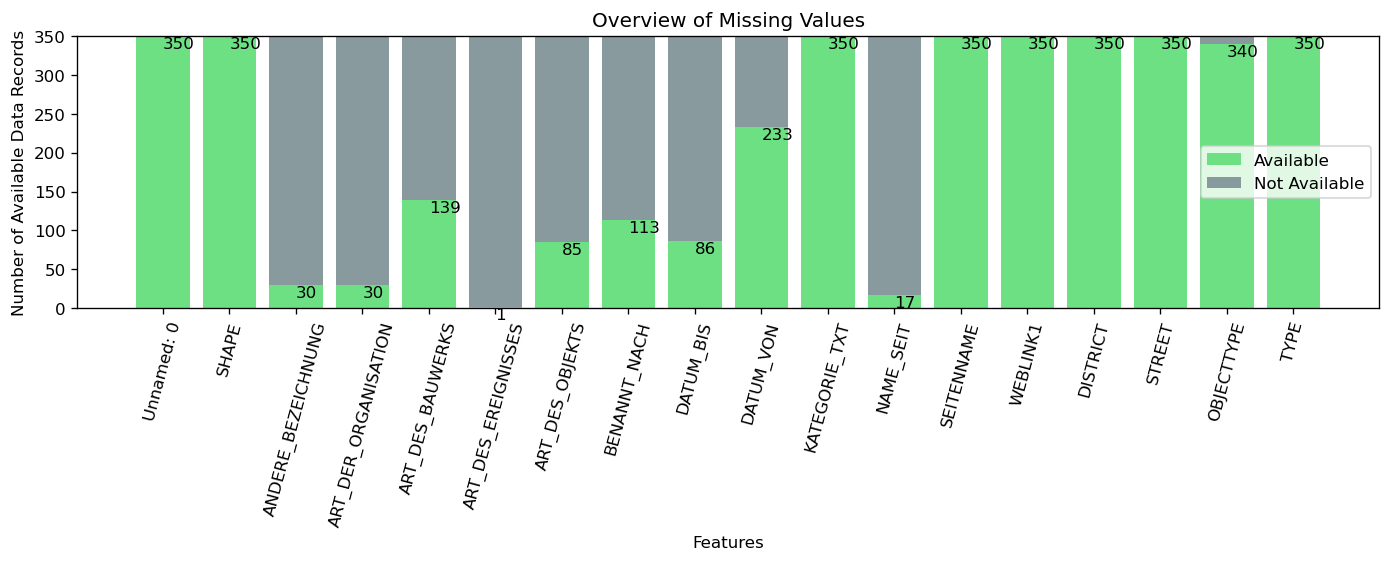

In [38]:
visualize_missing_values(df_extended)

<AxesSubplot:>

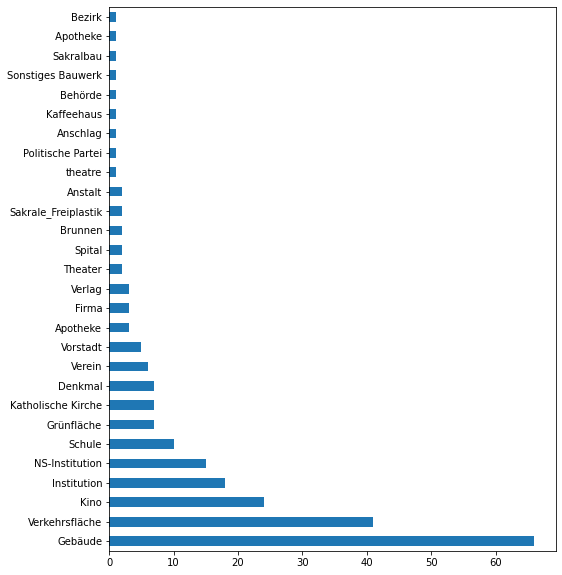

In [4]:


aggregated_df = df_extended[['SEITENNAME', 'TYPE', 'DATUM_VON', 'DATUM_BIS', 
                             'BENANNT_NACH', 'STREET', 'DISTRICT', 'SHAPE', 'WEBLINK1']].copy()

aggregated_df['DATUM_VON'] = aggregated_df['DATUM_VON'].fillna(0).astype('int64', errors='ignore')
aggregated_df['DATUM_BIS'] = aggregated_df['DATUM_BIS'].fillna(0).astype('int64', errors='ignore')


aggregated_df.loc[df_extended["SEITENNAME"].str.contains("Volkstheater", case=False), "DATUM_VON"] = 1889
aggregated_df.loc[df_extended["SEITENNAME"].str.contains("Volkstheater", case=False), "TYPE"] = "theatre"

aggregated_df = aggregated_df.drop(aggregated_df[aggregated_df.DATUM_VON == 0].index)


aggregated_df.TYPE.value_counts().plot(kind='barh',figsize=(8,10))

### Aggregate and Remove Object types

In [5]:

aggregated_df.reset_index(inplace=True)
aggregated_df.drop("index", axis=1, inplace=True)

#aggregating
aggregated_df["TYPE"].replace("^Sakrale_Freiplastik|Denkmal", "statue", regex=True, inplace=True)
aggregated_df["TYPE"].replace("Katholische Kirche", "church", regex=True, inplace=True)

aggregated_df["TYPE"].replace("^Spital|.*Apotheke.*", "health_institution", regex=True, inplace=True)

aggregated_df["TYPE"].replace("^Sonstiges Bauwerk|Gebäude", "building", regex=True, inplace=True)
aggregated_df["TYPE"].replace("^Institution|^Verein", "building", regex=True, inplace=True)


#translating
aggregated_df["TYPE"].replace("Kino", "cinema", regex=True, inplace=True)
aggregated_df["TYPE"].replace("Kaffeehaus", "coffee_house", regex=True, inplace=True)
aggregated_df["TYPE"].replace("^Grünfläche", "park", regex=True, inplace=True)
aggregated_df["TYPE"].replace("^Schule", "school", regex=True, inplace=True)
aggregated_df["TYPE"].replace("^NS-Institution", "NS_institution", regex=True, inplace=True)
aggregated_df["TYPE"].replace("^Vorstadt", "settlement", regex=True, inplace=True)
aggregated_df["TYPE"].replace("^Theater", "theatre", regex=True, inplace=True)


aggregated_df.replace("ä", "ae", regex=True, inplace=True)
aggregated_df.replace("ö", "oe", regex=True, inplace=True)
aggregated_df.replace("ü", "ue", regex=True, inplace=True)
aggregated_df.replace("è", "e", regex=True, inplace=True)
aggregated_df.replace("é", "e", regex=True, inplace=True)
aggregated_df.replace("á", "a", regex=True, inplace=True)
aggregated_df.replace("â", "a", regex=True, inplace=True)
aggregated_df.replace("à", "a", regex=True, inplace=True)
aggregated_df.replace("ß", "ss", regex=True, inplace=True)

#correcting values
aggregated_df.loc[aggregated_df['SEITENNAME'].str.contains("cafe", case=False), "TYPE"] = "coffee_house"
aggregated_df.loc[aggregated_df['SEITENNAME'].str.contains("spital", case=False), "TYPE"] = "health_institution"


#removing
aggregated_df["TYPE"].replace('''^Verkehrsflaeche|^Bezirk|^Gruenfläche|^Politische Partei|^Behoerde|^Ort
            |Insel|.*Topografi.*|^Ort|^Anstalt|^Sakralbau|Anschlag|Brunnen|^Verlag|^Firma''', "unwanted", regex=True, inplace=True)
aggregated_df = aggregated_df[aggregated_df.TYPE != "unwanted"].copy()





aggregated_df.loc[(aggregated_df['SEITENNAME'].str.contains("hof", case=False)) &
                  (aggregated_df['DATUM_VON']<1700), "TYPE"] = "farm"

In [6]:
# https://www.geschichtewiki.wien.gv.at/Neudeggerhof
aggregated_df.loc[aggregated_df["SEITENNAME"] == "Neudeggerhof", "DATUM_BIS"] = 1770

aggregated_df.loc[(aggregated_df['SEITENNAME'].str.contains("hof", case=False)) & (aggregated_df['DATUM_VON']<1700)]

,SEITENNAME,TYPE,DATUM_VON,DATUM_BIS,BENANNT_NACH,STREET,DISTRICT,SHAPE,WEBLINK1
70,Berchtesgadner Hof,farm,1333,1529,Probst von Berchtesgaden,Burggasse 22,7,POINT (16.352930991859658 48.20440306441252),https://www.geschichtewiki.wien.gv.at/?curid=3...
81,Oberhof,farm,1629,1788,NaN,Neustiftgasse 30,7,POINT (16.35165044544807 48.20558045755067),https://www.geschichtewiki.wien.gv.at/?curid=2...
94,"Schottenhof (7, Neustiftgasse 30-36)",farm,1629,1788,Schottenstift,Neustiftgasse 30,7,POINT (16.351678276390583 48.20551992939218),https://www.geschichtewiki.wien.gv.at/?curid=1...
99,Neudeggerhof,farm,1376,1770,NaN,Lerchenfelder Strasse 25,7,POINT (16.351909225942467 48.206229823002204),https://www.geschichtewiki.wien.gv.at/?curid=1...


In [7]:
aggregated_df.loc[(aggregated_df['SEITENNAME'].str.contains("theater", case=False))]

,SEITENNAME,TYPE,DATUM_VON,DATUM_BIS,BENANNT_NACH,STREET,DISTRICT,SHAPE,WEBLINK1
82,Theater der Jugend,theatre,1932,0,NaN,Neubaugasse 36/1,7,POINT (16.3494000247669 48.20136633307758),https://www.geschichtewiki.wien.gv.at/?curid=2...
97,Renaissancetheater,theatre,1912,0,NaN,Neubaugasse 36/1,7,POINT (16.3494000247669 48.20136633307758),https://www.geschichtewiki.wien.gv.at/?curid=2...
122,Volkstheater,theatre,1889,0,Verein des Deutschen Volkstheaters,Arthur-Schnitzler-Platz 1,7,POINT (16.357053732725316 48.20523201309908),https://www.geschichtewiki.wien.gv.at/?curid=6125
145,Biographen Theater Weingaertner,cinema,1907,1909,NaN,Mariahilfer Strasse 8,7,POINT (16.359713396007376 48.20144292132249),https://www.geschichtewiki.wien.gv.at/?curid=5...
146,Hackers Biographen Theater,cinema,1909,1917,NaN,Neubaugasse 4,7,POINT (16.349995792875152 48.198689876695106),https://www.geschichtewiki.wien.gv.at/?curid=5...
148,Kinematographentheater (Neubau),cinema,1909,1910,NaN,Kirchengasse 43,7,POINT (16.351401399374048 48.20507003547661),https://www.geschichtewiki.wien.gv.at/?curid=5...


In [8]:
aggregated_df['LONG'] = aggregated_df['SHAPE'].str.extract(r'POINT \((\d+\.\d+)').astype(float)
aggregated_df['LAT'] = aggregated_df['SHAPE'].str.extract(r'(\d+\.\d+)\)').astype(float)


<AxesSubplot:>

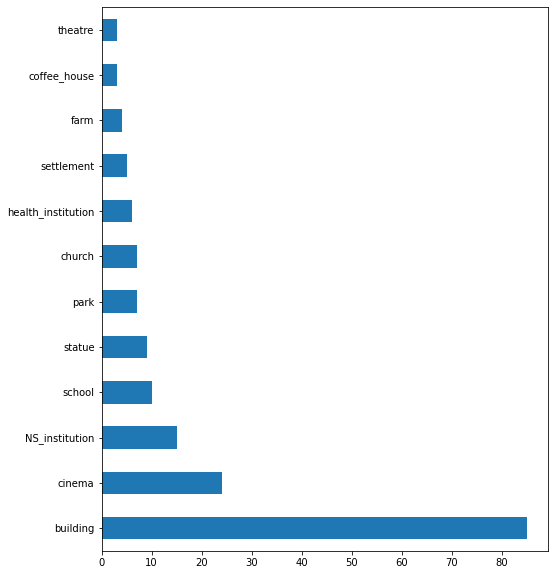

In [9]:
aggregated_df.TYPE.value_counts().plot(kind='barh',figsize=(8,10))

In [10]:
aggregated_df.to_csv("./data/district_data.csv", sep =";", index_label=False)

In [77]:
n= pd.read_csv("./data/district_data.csv", sep=";")

## Analysis of Development over Time

Text(0.5, 0, 'Year')

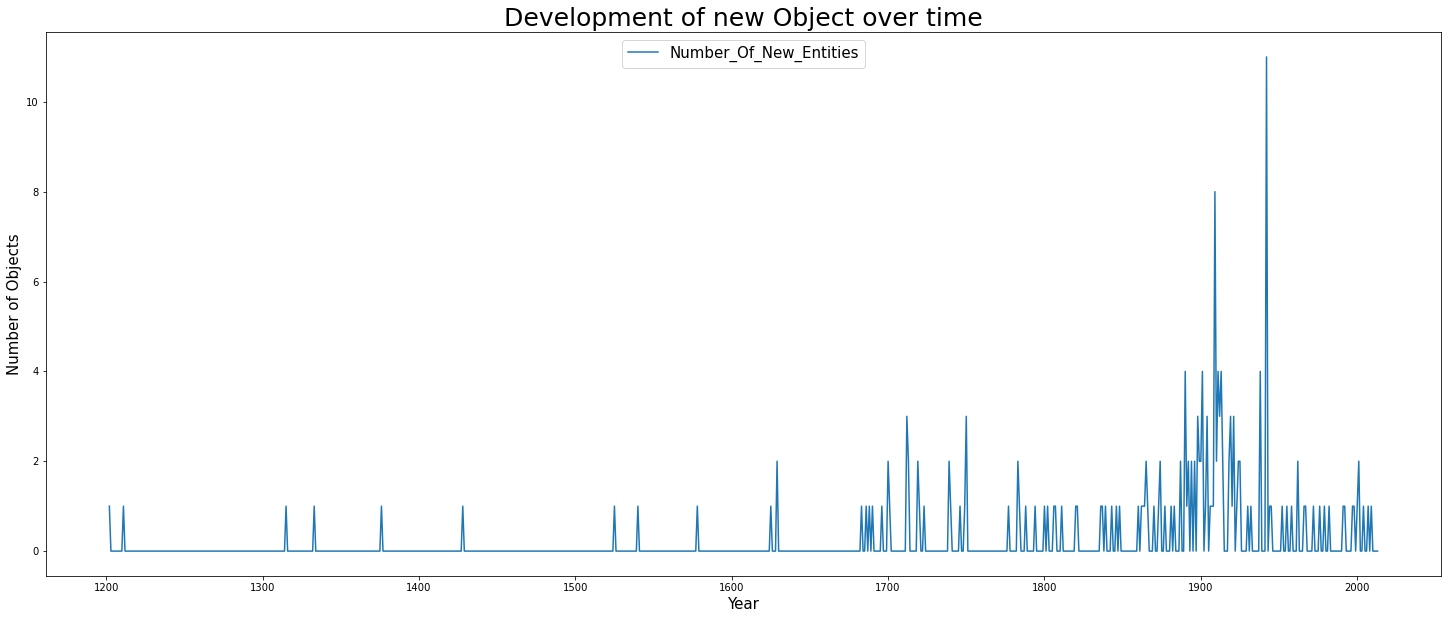

In [32]:
data_per_year = aggregated_df.groupby('DATUM_VON').count()['SEITENNAME']
data_per_year = data_per_year.to_frame().rename(columns={'SEITENNAME':'Number_Of_New_Entities'})


all_years = pd.Series(np.arange(aggregated_df['DATUM_VON'].min(), aggregated_df['DATUM_VON'].max())).to_frame()
all_years['Number_Of_New_Entities'] = 0
all_years.set_index(0, inplace=True)



data_per_year = all_years.combine(data_per_year, np.maximum).fillna(0)

ax = data_per_year.plot(figsize=(25,10))

ax.set_title('Development of new Object over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 15})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

(0.0, 186.9)

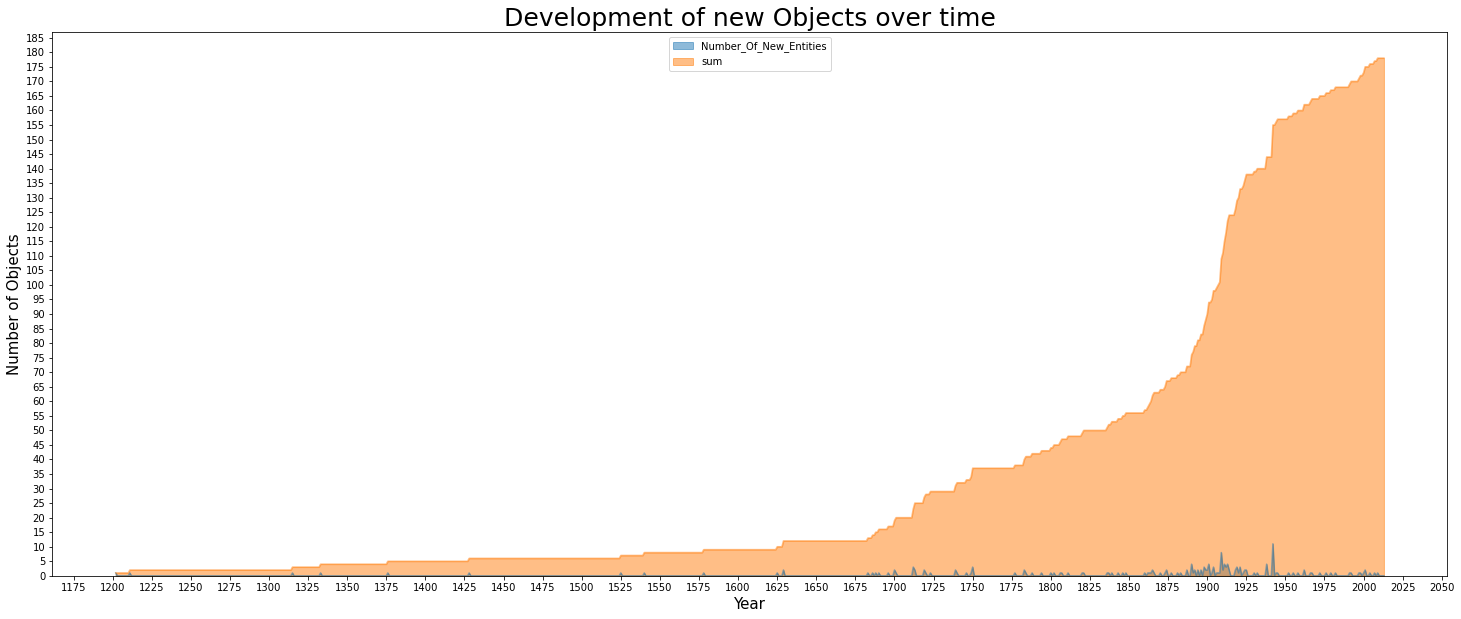

In [33]:

data_per_year = data_per_year.assign(sum=data_per_year.values.cumsum())

ax = data_per_year.plot(kind ='area',figsize=(25,10), stacked=False)

ax.set_title('Development of new Objects over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 10})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

#display xasis as integer and set how many years should be displayed
ax.locator_params(integer=True, nbins=20, min_n_ticks=20)
ax.set_ylim(ymin=0)

Text(0.5, 0, 'Year')

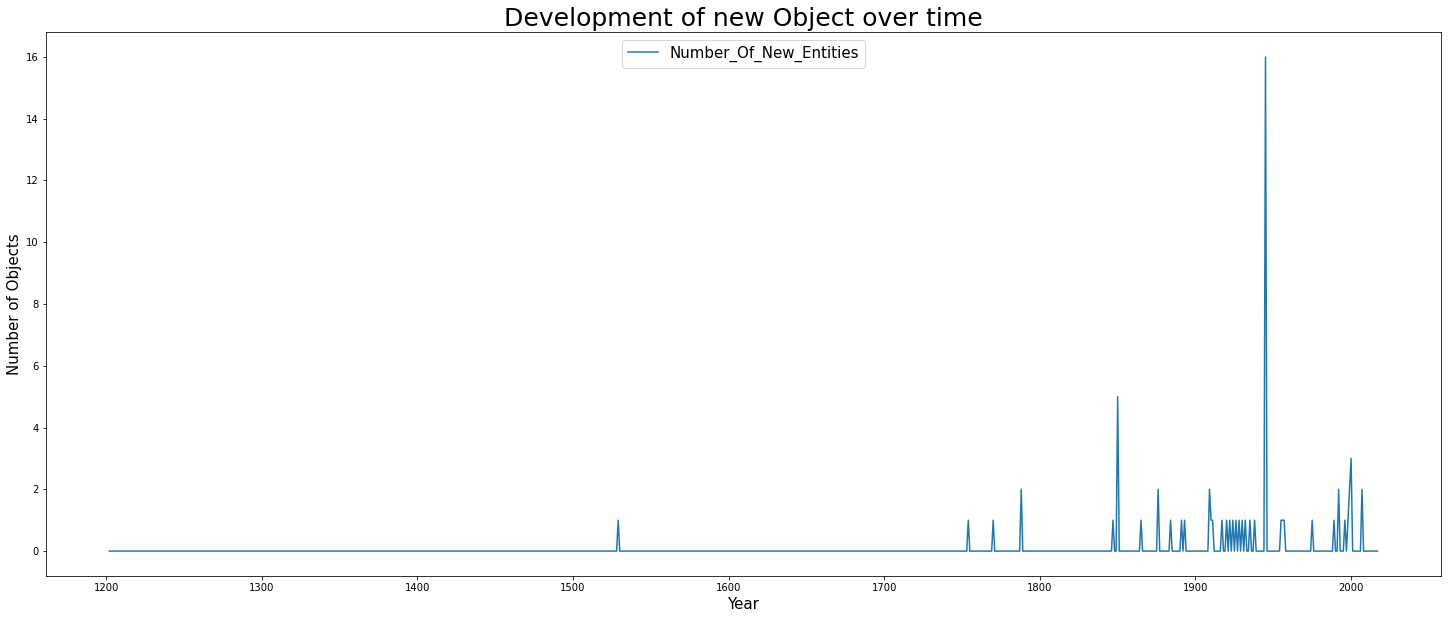

In [34]:
data_per_year = aggregated_df.drop(aggregated_df[aggregated_df['DATUM_BIS'] == 0].index).groupby('DATUM_BIS').count()['SEITENNAME']
data_per_year = data_per_year.to_frame().rename(columns={'SEITENNAME':'Number_Of_New_Entities'})


all_years = pd.Series(np.arange(aggregated_df['DATUM_VON'].min(), aggregated_df['DATUM_BIS'].max())).to_frame()
all_years['Number_Of_New_Entities'] = 0
all_years.set_index(0, inplace=True)



data_per_year = all_years.combine(data_per_year, np.maximum).fillna(0)

ax = data_per_year.plot(figsize=(25,10))

ax.set_title('Development of new Object over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 15})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

(0.0, 66.15)

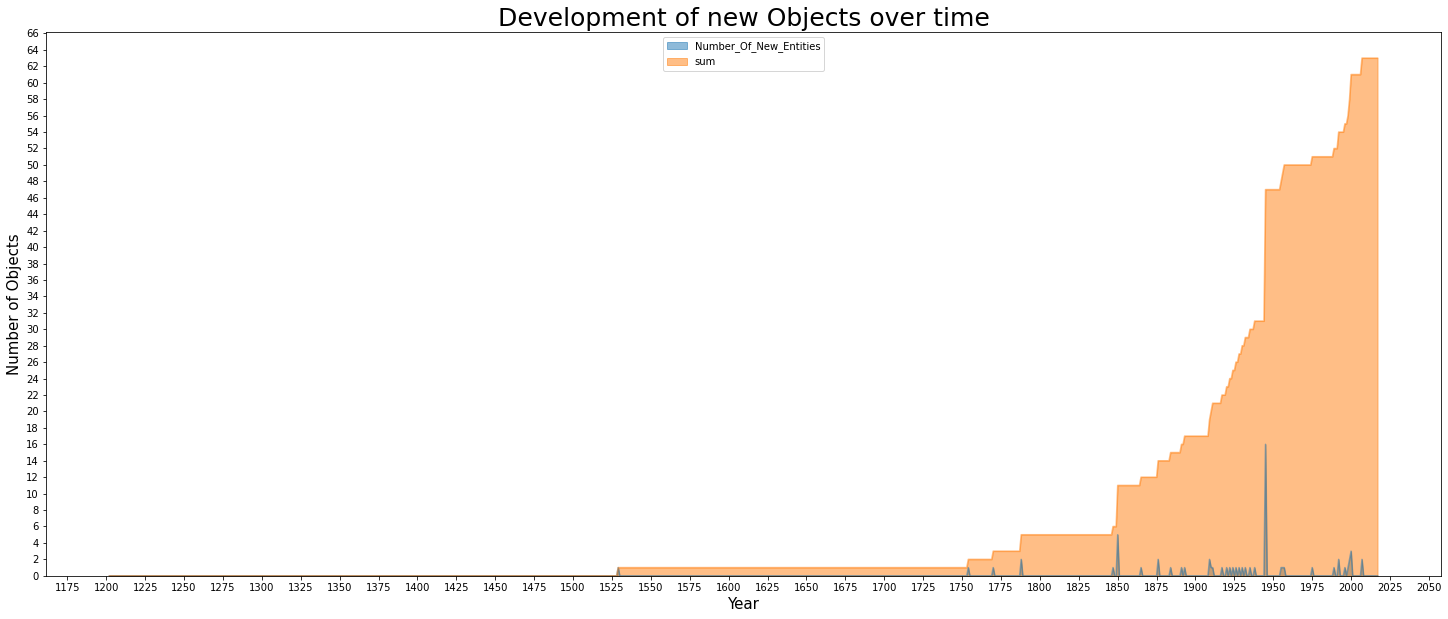

In [35]:
data_per_year = data_per_year.assign(sum=data_per_year.values.cumsum())

ax = data_per_year.plot(kind ='area',figsize=(25,10), stacked=False)

ax.set_title('Development of new Objects over time')
ax.title.set_size(25)
ax.legend(loc=9, prop={'size': 10})
ax.set_ylabel('Number of Objects', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

#display xasis as integer and set how many years should be displayed
ax.locator_params(integer=True, nbins=20, min_n_ticks=20)
ax.set_ylim(ymin=0)

## Handle the coordinates file

In [36]:
coord_df = pd.read_csv("./data/BEZIRKSGRENZEOGD.csv")

In [37]:
coord_df[]

SyntaxError: invalid syntax (<ipython-input-37-75f8a3b56913>, line 1)